In [112]:
import torch
import torch.nn as nn
import numpy as np

LOG = False
def log(*args):
    global LOG
    if LOG:
        print(*args)

class DeepNNModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=32):
        super(DeepNNModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.predictor = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Sigmoid(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Sigmoid(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Sigmoid(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Sigmoid(),
            nn.Linear(hidden_dim, 1)


        )

    def forward(self, x):

        log(f"Input shape: {x.shape}")
        output = self.predictor(x)  

        return output

    def train_model(self, data, device='cpu', num_epochs=50, patience=5, learning_rate=0.01):
        self.to(device)
        self.train()
        
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        criterion = nn.L1Loss() # Using L1 loss for regression tasks

        best_loss = float('inf')
        epochs_without_improvement = 0

        for epoch in range(num_epochs):
            total_loss = 0.0
            train_losses = []

            for inputs, targets in data:
                
                inputs = inputs.to(device)
                targets = targets.to(device)

                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs.squeeze(), targets.float())
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                train_losses.append(loss.item())

            avg_loss = total_loss / len(data)


            if avg_loss < best_loss:
                best_loss = avg_loss
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1

            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

            if epochs_without_improvement >= patience:
                print("Early stopping triggered.")
                break

        torch.save(self.state_dict(), 'best_model.pth')
        print("Training complete.")

    @classmethod
    def load_model(cls, checkpoint_path, device='cpu', **kwargs):
        """
        Loads a trained AttentionModel.
        Args:
            checkpoint_path (str): Path to saved .pth file.
            device (str): 'cpu' or 'cuda'.
            kwargs: Keyword arguments for the model constructor (e.g., input_dim, hidden_dim)
        Returns:
            AttentionModel instance with weights loaded.
        """
        model = cls(**kwargs)
        model.load_state_dict(torch.load(checkpoint_path, map_location=device))
        model.to(device)
        model.eval()
        return model

Downloading:  XRP-USD
2769


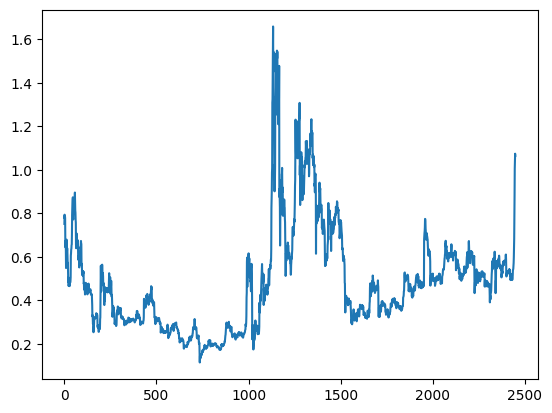

torch.Size([32, 120])


In [113]:
from matplotlib import pyplot as plt
import stock_libs
import stock_libs.yhf_lib


INPUT_DIM = 120
HOLDOUT = 200
#X = torch.tensor([(np.sin(np.pi*i/24)+torch.rand(1,1)+(0.01*i)).tolist() for i in range(1000)])
#X = torch.tensor([(np.sqrt(0.01*i)+np.sin(i/250)*torch.ones(1,1)).tolist() for i in range(1000)])

def build_real_data_set(symbol):
    real_data = stock_libs.yhf_lib.download_code(symbol, download_data=True, force_download=True, path="..")
    print(len(real_data))
    #real_data =  torch.tensor([(np.sqrt(0.01*i)+np.sin(i/250)*torch.ones(1,1)).tolist() for i in range(1000)])
    #X = real_data
    X = torch.tensor([(real_data["Low"].iloc[i]*torch.ones(1,1)).tolist() for i in range(0,len(real_data))])
    Xtrunc = X[:len(real_data)-HOLDOUT]

    return X, Xtrunc 

Xfull, X = build_real_data_set("XRP-USD")


plt.plot(X[INPUT_DIM:].squeeze(-1).detach().numpy(), label='Actual')
plt.show()
# Y = torch.tensor([0 if sum(x)> 0 else 1  for x in X])
# print(len(X), len(Y))

def build_training_data(X, batches = 100, length=30, batch_size=32):
    training_data = []
    if len(X) < length:
        raise ValueError("Input data length must be at least equal to the specified length.")
    
    for i in range(batches):
        batchX = []
        batchY=[]
        for _ in range(batch_size):
            start = np.random.randint(0, len(X) - length)
            end = start + length
            batchX.append(X[start:end])
            batchY.append(X[end])
        training_data.append((torch.stack(batchX).squeeze(-1).squeeze(-1), torch.tensor(batchY)))

    return training_data



data = build_training_data(X,batches=100, length=INPUT_DIM, batch_size=32)
 
print(data[0][0].shape)


In [114]:
model = DeepNNModel(input_dim=INPUT_DIM, hidden_dim=256)

model.train_model(data=data, device='cpu', num_epochs=500, patience=100, learning_rate=0.0001)
#


yhat = model(data[0][0].unsqueeze(0).float())


# from torchviz import make_dot
# make_dot(yhat, params=dict(list(model.named_parameters()))).render("model_architecture", format="png")


Epoch 1/500, Loss: 0.1780
Epoch 2/500, Loss: 0.1742
Epoch 3/500, Loss: 0.1509
Epoch 4/500, Loss: 0.0937
Epoch 5/500, Loss: 0.0810
Epoch 6/500, Loss: 0.0715
Epoch 7/500, Loss: 0.0613
Epoch 8/500, Loss: 0.0551
Epoch 9/500, Loss: 0.0527
Epoch 10/500, Loss: 0.0496
Epoch 11/500, Loss: 0.0474
Epoch 12/500, Loss: 0.0462
Epoch 13/500, Loss: 0.0452
Epoch 14/500, Loss: 0.0437
Epoch 15/500, Loss: 0.0421
Epoch 16/500, Loss: 0.0407
Epoch 17/500, Loss: 0.0403
Epoch 18/500, Loss: 0.0388
Epoch 19/500, Loss: 0.0389
Epoch 20/500, Loss: 0.0378
Epoch 21/500, Loss: 0.0372
Epoch 22/500, Loss: 0.0365
Epoch 23/500, Loss: 0.0363
Epoch 24/500, Loss: 0.0353
Epoch 25/500, Loss: 0.0348
Epoch 26/500, Loss: 0.0346
Epoch 27/500, Loss: 0.0345
Epoch 28/500, Loss: 0.0335
Epoch 29/500, Loss: 0.0338
Epoch 30/500, Loss: 0.0334
Epoch 31/500, Loss: 0.0330
Epoch 32/500, Loss: 0.0326
Epoch 33/500, Loss: 0.0320
Epoch 34/500, Loss: 0.0318
Epoch 35/500, Loss: 0.0315
Epoch 36/500, Loss: 0.0313
Epoch 37/500, Loss: 0.0307
Epoch 38/5

torch.Size([200]) 2769 -700
torch.Size([2449])


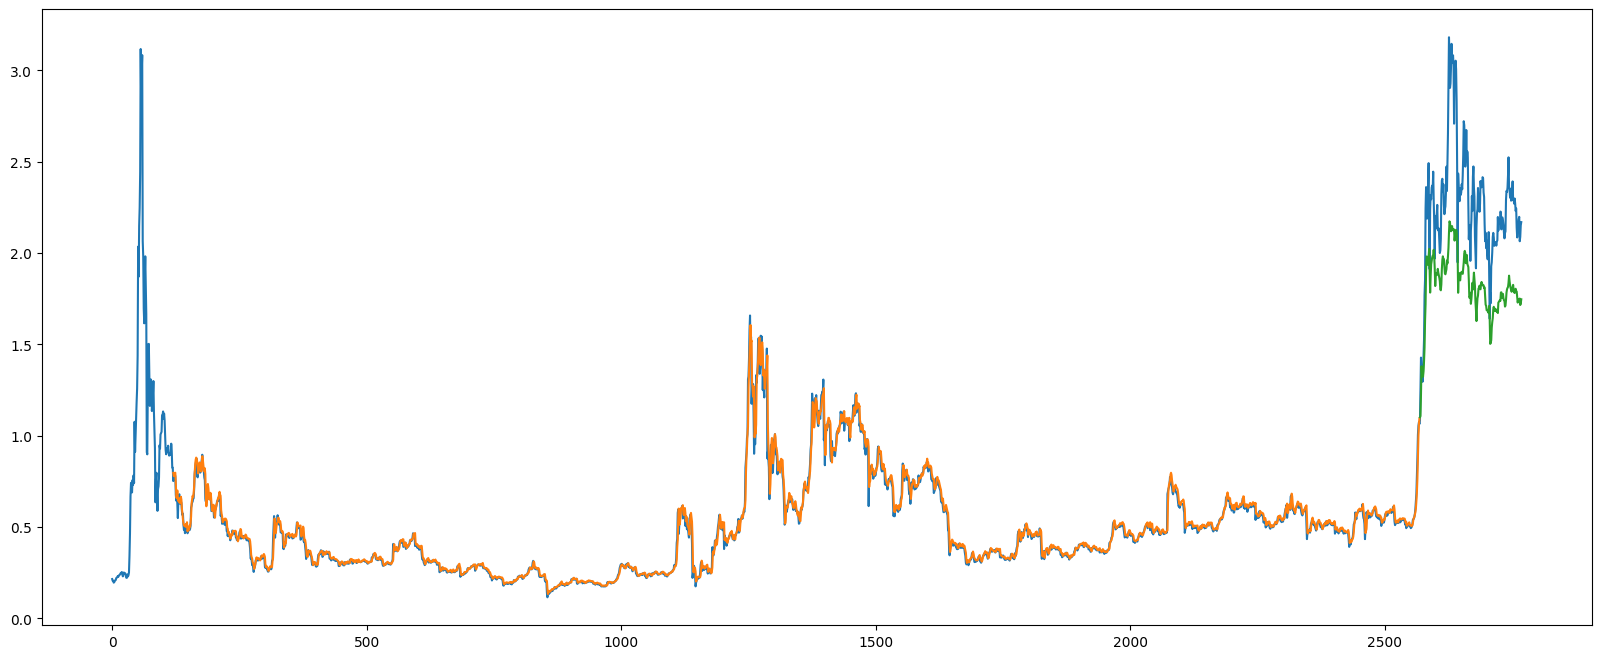

In [115]:
PRE_LOAD = 500
x_hat = []

l = len(Xfull) - HOLDOUT
##
for idx in range(0,HOLDOUT):
    x = Xfull[l+idx-INPUT_DIM:l+idx]
    #print(len(x), idx, "ST_", l+idx-INPUT_DIM, "END_", l+idx, ">>",(l+idx-INPUT_DIM-(l+idx)), "BASE_C", l , "LEN_C",len(Xfull))
    yhat = model(x.squeeze(-1).transpose(0,1))
    x_hat.append(yhat[0].detach().numpy())

##
stable = []
for idx in range(INPUT_DIM, len(Xfull)-HOLDOUT):
    x = X[idx-INPUT_DIM:idx]
    #print(x.shape)
    yhat = model(x.squeeze(-1).transpose(0,1))
    stable.append(yhat[0].detach().numpy())

x_hat = torch.tensor(x_hat).squeeze(-1)
print(x_hat.shape, len(Xfull), -HOLDOUT-PRE_LOAD)
stable = torch.tensor(stable).squeeze(-1)
print(stable.shape)

ax, fig = plt.subplots(1, 1, figsize=(20, 8))
#fig[0].plot(model.attn_alpha[0])

fig.plot(Xfull.squeeze(-1).detach().numpy(), label='Actual')
fig.plot(list([i for i in range(INPUT_DIM,len(Xfull)-HOLDOUT)]), stable.detach().numpy(), label='Stable')
fig.plot(list([i for i in range(len(Xfull)-(HOLDOUT),len(Xfull))]), x_hat.detach().numpy(), label='Forecast')

plt.show()



